In [11]:
import glob
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from natsort import natsorted
from scipy.stats import describe
from scipy.signal import filtfilt
from sklearn.metrics import mean_squared_error

In [12]:
path = '/Users/patrick/Documents/phd/GitHub/tikhonov/'

In [3]:
g4iso_files = natsorted(glob.glob(path+"g4out/*KE_*_iso.csv"))
R = []
D = []

for i in range(10,len(g4iso_files)-1,5): # 100 keV to 1 MeV energy range in steps of 100 keV
    R.append(np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=9)[30:500:1,3]/5000000.0)
    #print(g4iso_files[i])
R = np.transpose(np.array(R))
RR = R
for j in range(0,470): # X-ray spectra from 0 to 600 keV
    if (np.linalg.norm(R[j,:] > 0)):
        D.append((1.0/np.linalg.norm(R[j,:]))) # Diagonal scaling as a left pre-conditioner
    else:
        D.append(1)

DD = np.diag(D)
RT = np.matmul(DD,R)

S = []
for k in range(0,R.shape[1]):
    #S.append(1.0/(k+1)**2) # right pre-conditioner towards an exponential
    S.append(1.0/np.sum(R[:,k]))
    #S.append(alexa_model_exp[k])
    #S.append(1)
SS = np.diag(S)
RS = np.matmul(RT,SS)

print('response condition number: ' + str(np.linalg.cond(R)))
print('response condition number after preconditioning: ' + str(np.linalg.cond(RS)))

elow_keV = 110
ehigh_keV = 1960
xspace_estep_keV = 1
espace_estep_keV = 50

espace = np.linspace(elow_keV,ehigh_keV,R.shape[1])
xspace = np.linspace(30,500,R.shape[0])




response condition number: 15993.388434442719
response condition number after preconditioning: 173.12830996456782


In [4]:
def nmse(actual,predicted): # normalized mean-squared error 
    error = actual - predicted
    return(np.dot(np.transpose(error),error)/np.dot(np.transpose(actual),actual))

In [5]:
# implement tikhonov regularization for orders 0 through 2 with option for positivity constraint

L0 = np.identity(R.shape[1])       # zeroth-order

L1 = np.copy(L0) 
for i in range(0, R.shape[1] - 1): # first-order
    L1[i,i+1] = -1.0

L2 = np.copy(L0)
for i in range(1, R.shape[1]-1):  # second-order
    L2[i,i] = -2.0
    L2[i,i+1] = 1.0 
    L2[i,i-1] = 1.0

def tk(R, op, kappa, xs, posonly):
    C = np.matmul(np.transpose(R),R) + (kappa**2)*np.matmul(np.transpose(op),op)
    D = np.matmul(np.transpose(R), xs)        
    if (posonly):
        sol = scipy.optimize.nnls(C,D,maxiter=1e10)[0]
    else:
        sol = np.linalg.solve(C,D)
    error = (np.linalg.norm(np.matmul(R,sol) - xs))
    bias = np.linalg.norm((kappa)*np.matmul(op,sol))
    return(sol,error,bias)

In [6]:
# generate synthetic data 

e0 = np.linspace(30, 299, R.shape[0])
e1 = np.linspace(100, ehigh_keV, R.shape[1])

def bg(total):
    beam = np.full(len(espace), 0)
    signal = np.full(len(xspace), 0)
    for e in range(0, e0.shape[0]): # normally distributed noise
        signal[e] = abs(signal[e] + np.random.normal(signal[e],np.sqrt(total/len(espace))))
    return((signal,beam))

def ex(fold, elow, ehigh, total):
    beam = np.exp(-e1/fold)
    beam[0:(np.abs(e1 - elow)).argmin()] = 0.0
    beam[(np.abs(e1 - ehigh)).argmin():-1] = 0.0
    integral = np.trapz(beam,e1)
    beam = beam*total/integral # beam should integrate to total e-/cm^2/s
    
    signal = np.matmul(R,beam)
    
    for e in range(0, e0.shape[0]):
        signal[e] = abs(signal[e] + np.random.normal(signal[e],np.sqrt(signal[e])))
        
    return(signal,beam)

def gauss(mu, sig, elow, ehigh, total):
    beam = total*np.exp(-np.power(e1 - mu, 2.) / (2 * np.power(sig, 2.)))
    beam[0:(np.abs(e1 - elow)).argmin()] = 0.0 # low and high energy cutoffs
    beam[(np.abs(e1 - ehigh)).argmin():-1] = 0.0
    integral = np.trapz(beam, x=e1)
    beam = beam*total/integral # beam should integrate to total e-/cm^2/s
    signal = np.matmul(R,beam)
    for e in range(0, e0.shape[0]): 
        signal[e] = np.random.normal(signal[e], scale=np.sqrt(signal[e]))
    return(signal,beam)

def mono(e, total):
    beam = np.full(e1.shape[0], 0.0)
    beam[(np.abs(e1 - e)).argmin()] = total
    signal = np.matmul(R,beam) # beam should integrate to total e-/cm^2/s
    for e in range(0, e0.shape[0]): 
        signal[e] = np.random.normal(signal[e], scale=np.sqrt(signal[e]))
    return((signal,beam))

In [7]:
# cross validation

def cv(R, op, kappas, xs, posonly):
    err = []
    for kappa in kappas:
        e = 0
        for i in range(0, len(xs) - 1):
            RST = np.delete(R,i,0)
            xst = np.delete(xs,i,0) # delete one X-ray data point and solve the reduced problem
            sol = np.matmul(tk(RST, op, kappa, xst, posonly)[0],SS)
            sol[-1] = 0
            e += (np.matmul(R,sol)[i] - xs[i])**2
        err.append(e)
    return(err)

In [8]:
L0 = np.identity(R.shape[1])       # zeroth-order

L1 = np.copy(L0) 
for i in range(0, R.shape[1] - 1): # first-order
    L1[i,i+1] = -1.0

L2 = np.copy(L0)
for i in range(1, R.shape[1]-1): # second-order
    L2[i,i] = -2.0
    L2[i,i+1] = 1.0 
    L2[i,i-1] = 1.0
L2[-1,-2] = 0
L2[0,0] = 1
L2[0,1] = 0

def tk(R, op, kappa, xs, posonly):
    C = np.matmul(np.transpose(R),R) + (kappa**2)*np.matmul(np.transpose(op),op)
    D = np.matmul(np.transpose(R), xs)
    if (posonly):
        sol = scipy.optimize.nnls(C,D,maxiter=1e10)[0]
    else:
        sol = np.linalg.solve(C,D)
    error = (np.linalg.norm(np.matmul(R,sol) - xs))
    bias = np.linalg.norm((1)*np.matmul(op,sol))
    return(sol,error,bias)

def tks(R, op, kappa, xs, posonly):
    eq = lambda e: np.linalg.norm(np.matmul(R,e) - xs) + kappa*np.linalg.norm(np.matmul(op,e))
    bnds=scipy.optimize.Bounds(np.full(R.shape[1],0), np.full(R.shape[1],np.inf))
    sol = scipy.optimize.minimize(eq,tk(R,op,kappa,xs,True)[0],options={"maxiter":1e40},bounds=bnds)
    return(sol.x)

In [9]:
from scipy.stats import moment

In [10]:
moment([1, 2, 3, 4, 5], moment=1)

0.0

In [140]:
RL = []
for i in range(10,len(g4iso_files)-1,5): # 100 keV to 1 MeV energy range in steps of 100 keV=
    RL.append(np.log(np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=9)[30:500:1,3]/5000000.0 + 0*1e-10))
RL = np.transpose(np.array(RL))


<ipython-input-140-0e720edbd439>:3: RuntimeWarning: divide by zero encountered in log
  RL.append(np.log(np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=9)[30:500:1,3]/5000000.0 + 0*1e-10))


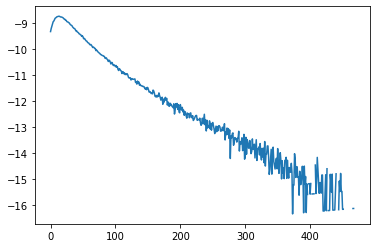

In [144]:
plt.plot(RL[:,10])

In [151]:
bm = mono(500,1e9)
bmm = mono(250,1e9)

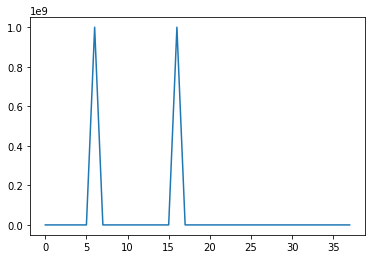

In [152]:
plt.plot(bm[1] + bmm[1])

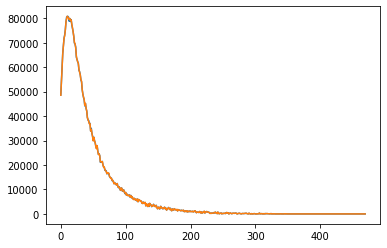

In [155]:
plt.plot(bmm[0])
plt.plot(np.matmul(R,bmm[1]))

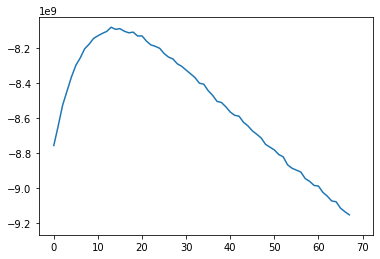

In [158]:
plt.plot(np.matmul(RL,bm[1]))

In [160]:
from scipy.stats import moment


In [189]:
bm = gauss(500,100,0,1000,1e100)

In [179]:
moment(bm[1],0)

1.0

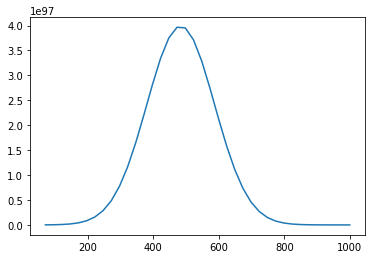

In [194]:
plt.plot(espace,bm[1])

In [180]:
moments = scipy.stats.describe(bm[1])

In [182]:
moments.mean

1081889.150506527

In [17]:
def n_weighted_moment(values, weights, n):

    assert n>0 & (values.shape == weights.shape)
    w_avg = np.average(values, weights = weights)
    w_var = np.sum(weights * (values - w_avg)**2)/np.sum(weights)

    if n==1:
        return w_avg
    elif n==2:
        return w_var
    else:
        w_std = np.sqrt(w_var)
        return np.sum(weights * ((values - w_avg)/w_std)**n)/np.sum(weights)
              #Same as np.average(((values - w_avg)/w_std)**n, weights=weights)

In [522]:
import math
n_weighted_moment(espace,bm[1],1)

483.3413688060136

In [16]:
def weighted_mean(var, wts):
    """Calculates the weighted mean"""
    return np.average(var, weights=wts)

In [203]:
weighted_mean(espace,bm[1])

483.3413688060136

In [322]:
RM = []
for i in range(10,len(g4iso_files)-1,5): # 100 keV to 1 MeV energy range in steps of 100 keV=
    RM.append(weighted_mean(xspace,np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=9)[30:500:1,3]/5000000.0))
RM = np.transpose(np.array(RM))
espaceM = np.linspace(elow_keV,ehigh_keV,RM.shape[0])


In [323]:
RM.shape

(38,)

In [260]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [207]:
espace.shape

(38,)

In [212]:
espace[]

497.29729729729735

In [213]:
RM[17]

98.00823970384631

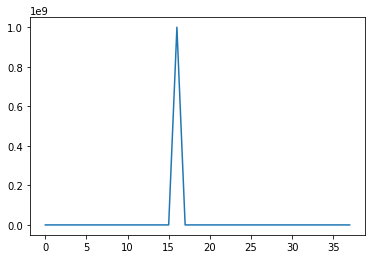

In [214]:
plt.plot(mono(500,1e9)[1])

In [381]:
weighted_mean(xspace,mono(500,1e9)[0]+mono(0,1e9)[0])

96.52188011711168

In [252]:
ff = ex(200,0,1000,1e10)

In [254]:
weighted_mean(espace,ff[1])

254.86494076851324

In [255]:
weighted_mean(xspace,ff[0])

96.53065574300796

In [228]:
weighted_mean(espace,tb[1])

254.86494076851326

In [259]:
weighted_mean(xspace,tb[0])

96.53399871331965

In [277]:
espaceM[np.argmin(np.abs(RM-96.53))]

460.7978723404255

In [324]:
np.matmul(RM,tb[1])

3143179216.2412333

In [273]:
espaceM

NameError: name 'espaceM' is not defined

In [368]:
RC = []
for i in range(10,len(g4iso_files)-1,5): # 100 keV to 1 MeV energy range in steps of 100 keV=
    RC.append(np.diff(np.append(0,np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=9)[30:500:1,3]/5000000.0)))
RC = np.transpose(np.array(RC))


In [369]:
RC.shape

(470, 38)

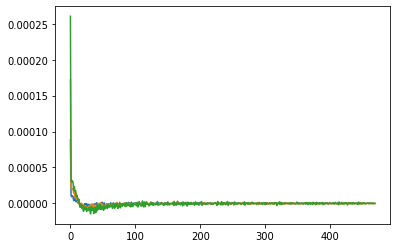

In [370]:
plt.plot(RC[:,10])
plt.plot(RC[:,17])
plt.plot(RC[:,17]+RC[:,10])

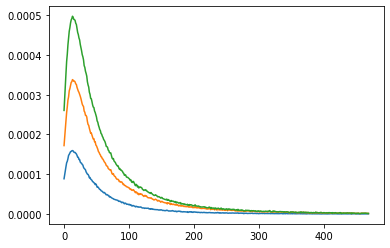

In [371]:
plt.plot(R[:,10])
plt.plot(R[:,17])
plt.plot(R[:,17]+R[:,10])

In [373]:
np.linalg.cond(RC)

1176.1823708687002

In [374]:
np.linalg.cond(R)

15993.388434442719

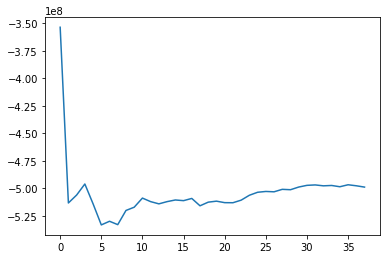

In [380]:
plt.plot(np.cumsum(np.matmul(np.linalg.pinv(RC),np.append(0,np.diff(tb[0])))))


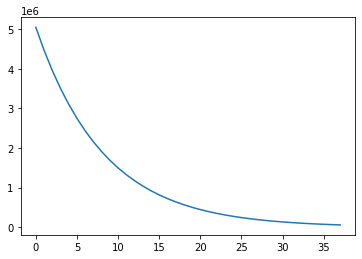

In [15]:
mx = []
my = []

beams = []
for i in range(1,1000,1):
    beams = [ex(i,0,1000,1e10),gauss(200,i,0,1000,1e10),gauss(i,500,0,1000,1e10),gauss(i,700,0,1000,1e10), gauss(i,100,0,1000,1e10),mono(i*10,1e10),ex(200,i,1000,1e10)]
    beams.append(gauss(500,400,0,i,1e10))
    beams.append(gauss(200,400,0,i,1e10))
    beams.append(gauss(100,400,0,i,1e10))
    beams.append(gauss(50,400,0,i,1e10))
    beams.append(gauss(np.random.rand()*1000,np.random.rand()*100,0,1000,1e10))
    for beam in beams:
        mx.append(weighted_mean(xspace,beam[0]))
        my.append(weighted_mean(espace,beam[1]))
    


NameError: name 'weighted_mean' is not defined

In [ ]:
    rr=np.abs(np.random.rand(espace.shape[0]))
    b, a = signal.butter(8, .1)
    randombeam  = [np.matmul(R,np.abs(signal.filtfilt(b, a, rr, padlen=20))),np.abs(signal.filtfilt(b, a, rr, padlen=20))]
    mx.append(weighted_mean(xspace,randombeam[0]))
    my.append(weighted_mean(espace,randombeam[1]))
    
    b, a = signal.butter(8, .2)
    randombeam  = [np.matmul(R,np.abs(signal.filtfilt(b, a, rr, padlen=20))),np.abs(signal.filtfilt(b, a, rr, padlen=20))]
    mx.append(weighted_mean(xspace,randombeam[0]))
    my.append(weighted_mean(espace,randombeam[1]))
    
    b, a = signal.butter(8, .06)
    randombeam  = [np.matmul(R,np.abs(signal.filtfilt(b, a, rr, padlen=20))),np.abs(signal.filtfilt(b, a, rr, padlen=20))]
    mx.append(weighted_mean(xspace,randombeam[0]))
    my.append(weighted_mean(espace,randombeam[1]))


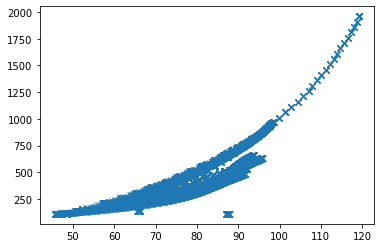

In [782]:
plt.plot(mx,my,'x')
#plt.ylim(200, 800)
#plt.xlim(105, 113)

In [740]:
for beam in beams:
    plt.plot(beam[1])

In [14]:
mx = []
my = []

beams = []
for i in range(1,5000,1):
    #beams = [ex(i,0,1000,1e10),gauss(200,i,0,1000,1e10),gauss(i,500,0,1000,1e10),gauss(i,700,0,1000,1e10), gauss(i,100,0,1000,1e10),mono(i*10,1e10),ex(200,i,1000,1e10)]
    #beams.append(gauss(500,400,0,i,1e10))
    #beams.append(gauss(200,400,0,i,1e10))
    #beams.append(gauss(100,400,0,i,1e10))
    #beams.append(gauss(50,400,0,i,1e10))


    rr=np.abs(np.random.rand(espace.shape[0]))
    rr[rr<0] = 0.0ff
    b, a = signal.butter(8, np.random.rand())
    randombeam  = [np.matmul(R,np.abs(signal.filtfilt(b, a, rr, padlen=20))),np.abs(signal.filtfilt(b, a, rr, padlen=20))]
    mx.append(n_weighted_moment(xspace,randombeam[0],2))
    my.append(n_weighted_moment(espace,randombeam[1],2))
    beams.append(randombeam)


NameError: name 'signal' is not defined

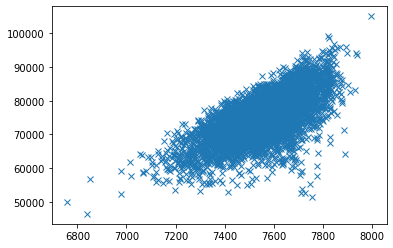

In [677]:
plt.plot(mx,my,'x')


In [678]:
espace

array([  70.        ,   95.13513514,  120.27027027,  145.40540541,
        170.54054054,  195.67567568,  220.81081081,  245.94594595,
        271.08108108,  296.21621622,  321.35135135,  346.48648649,
        371.62162162,  396.75675676,  421.89189189,  447.02702703,
        472.16216216,  497.2972973 ,  522.43243243,  547.56756757,
        572.7027027 ,  597.83783784,  622.97297297,  648.10810811,
        673.24324324,  698.37837838,  723.51351351,  748.64864865,
        773.78378378,  798.91891892,  824.05405405,  849.18918919,
        874.32432432,  899.45945946,  924.59459459,  949.72972973,
        974.86486486, 1000.        ])

In [713]:
np.random.rand()*100

92.21275647331537

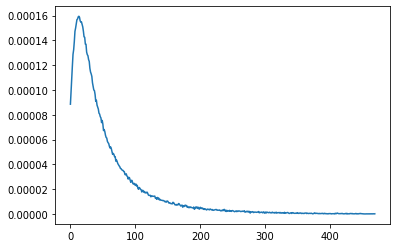

In [11]:
plt.plot(R[:,10])

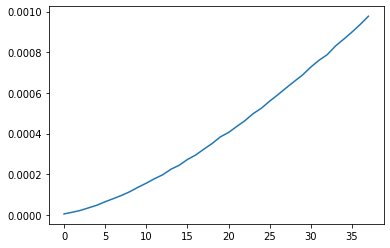

NameError: name 'heretic' is not defined